In [1]:
from __future__ import division

import json
from glob import glob
from tqdm import tqdm
import sys, os
import pandas as pd
import scanpy as sc
import scvelo as scv
import hotspot
import numpy as np
import scipy
from scipy import stats
import itertools
import warnings
from collections import OrderedDict 
from scipy.stats import zscore
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics.pairwise import cosine_similarity as cosine_similarity_sklearn
import anndata
#plotting
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import seaborn as sns
warnings.simplefilter(action='ignore', category=FutureWarning)

Global seed set to 0
/gstore/home/melocars/.conda/envs/mambapy38/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/gstore/home/melocars/.conda/envs/mambapy38/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
sys.path.append("utils/")
import utils as utils

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# Plotting style
sc.settings.set_figure_params(dpi=120, fontsize=10, dpi_save=300, frameon=False, format='pdf')
sc.settings.verbosity = 0
sns.set_style(style="white")
sns.set_style("ticks")

# Load modules

In [5]:
import json

clean_modules = "data/clean_modules_IP_IT.json"

with open(clean_modules) as json_file:
    genes = json.load(json_file)

In [6]:
baseline_studies = ['Chakarov', 'Schyns', 'Travaglini_mouse', 'Dicks', 'ural']

injury_studies  = ['LAM', 'osteopontin', 'cardiac', 'IL17', 'asbestos', 'peyser', '2019_Strunz']

cruz_studies = ['IP', 'IT']

baseline_studies_labels = ['Chakarov et al.', 'Schyns el al.', 'Travaglini et al.', 'Dicks et al.', 'Ural et al.']

In [7]:
clusters = {
    'M':['M1', 'M2', 'M3', 'M4'],
    'I':['I1', 'I2', 'I3', 'I4'],
    'A':['A1', 'A2', 'A3']
}

colors = {
    'M': np.array(['tab:purple', '#949494', '#ece133', '#cc78bc'], dtype=object),
    'I': np.array(['#029e73', '#d55e00', '#0173b2', '#de8f05'], dtype=object),
    'A': np.array(['#56b4e9', '#fbafe4', '#ca9161'], dtype=object)}

order_clusters = ["I4", "I3", "I2", "I1", "M4", "M3", "M2", "M1", "A2", "A1", "A3"]

# Load metadata

In [8]:
datasets_df = pd.read_csv("data/external_datasets_metadata.csv").set_index("index")
datasets_df.index.name = None

In [9]:
# Create dictionary for easy access
datasets = {}
for el in datasets_df.index:
    datasets[el] = {}
    for c in ['study_annotation', 'practical_annotation', 'state', 'organism', 'author', 'tissue']:
        datasets[el][c] = datasets_df.loc[el][c]

In [10]:
# Separate datasets according to tissue

tissue_datasets = {}
for el in datasets_df['tissue'].unique():
    tissue_datasets[el] = datasets_df[datasets_df['tissue']==el].index.tolist()
    print(el, len(tissue_datasets[el]))

Lung 10
Adipose 1
Liver 1
Heart 1
Skeletal muscle 1


# Load data

In [11]:
agg = {}

for t in tqdm(tissue_datasets):
    agg[t] = {}
    for el in tissue_datasets[t]:
        if el == 'IP' or el == 'IT':
            f = f"data/{el}.proc.myeloid.h5ad"
        else:
            f = f"data/external/{el}.proc.myeloid.h5ad"
        agg[t][el] = sc.read_h5ad(f)

100%|██████████| 5/5 [00:37<00:00,  7.46s/it]


# Data integration

In [12]:
adata = agg['Lung']['IP'].concatenate(*[agg[organ][study] for organ in agg for study in agg[organ] if study != 'IP'])

adata = utils.data_integration(adata)

Putting back counts layers as X
normalizing
selecting highly variable genes
Done selecting 2236 highly variable genes
computing PCA
batch correcting


2024-09-11 14:15:48,888 - harmonypy - INFO - Iteration 1 of 50
2024-09-11 14:16:15,241 - harmonypy - INFO - Iteration 2 of 50
2024-09-11 14:16:41,111 - harmonypy - INFO - Converged after 2 iterations


computing UMAP


# Figure 6c

In [13]:
anchor = 'aNotch2 IP'

In [14]:
cs = utils.cosine_similarity(adata, 'study_concise_annotation', 'X_pca_harmony')

In [15]:
cnts = utils.process_cosine_plot(adata=adata, cosine=cs, anchor=anchor).reset_index()

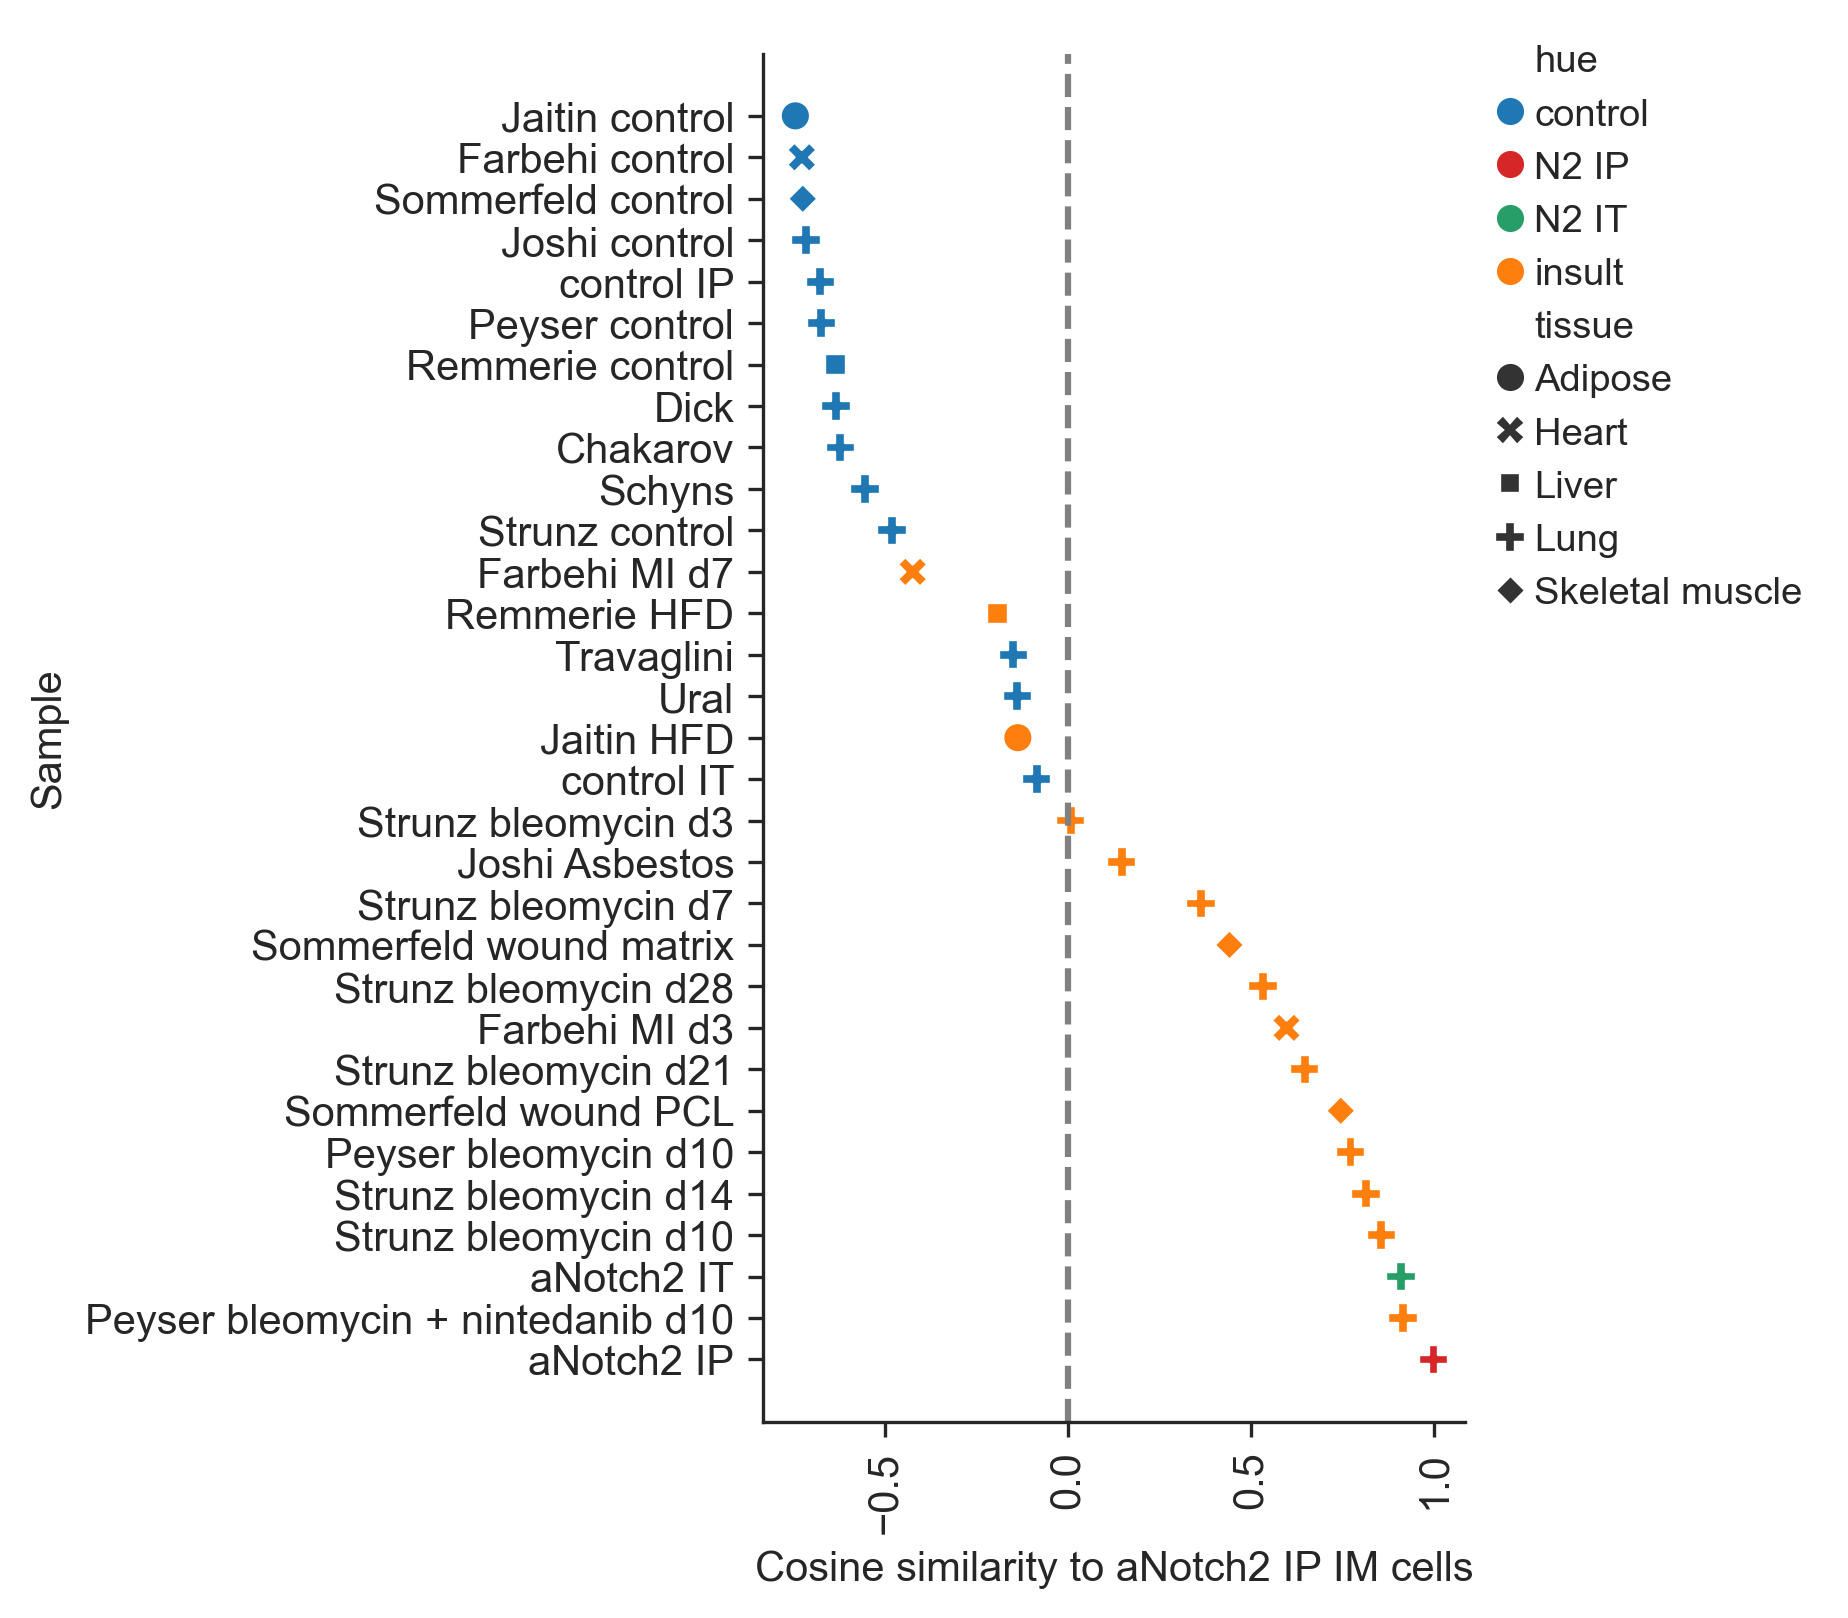

In [16]:
with plt.rc_context({"figure.dpi": (150)}):
    f, ax = plt.subplots(figsize=(3, 6))
    sns.scatterplot(data=cnts[::-1].reset_index(), y='index', x=anchor, ax=ax, hue='hue', 
                    hue_order=['control','N2 IP', 'N2 IT',  'insult'], 
                    style='tissue', size_norm=(0,60), s=50, 
                    palette=['#1f77b4', '#d62728', '#279e68', '#ff7f0e']
                   )
    ax.axvline(0, color='grey', linestyle='--')
    ax.grid(False)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.8), frameon=False, ncols=1)
    ax.set_xlabel('Cosine similarity to aNotch2 IP IM cells')
    ax.set_ylabel('Sample')
    sns.despine()

# Supplementary Figure 6a

In [17]:
bleo = sc.read_h5ad("data/bleo.proc.myeloid.h5ad")

In [18]:
adata = agg['Lung']['IP'].concatenate(*[agg[organ][study] for organ in agg for study in agg[organ] if study != 'IP'] + [bleo])

In [19]:
adata = utils.data_integration(adata)

Putting back counts layers as X
normalizing
selecting highly variable genes
Done selecting 2201 highly variable genes
computing PCA
batch correcting


2024-09-11 14:22:28,280 - harmonypy - INFO - Iteration 1 of 50
2024-09-11 14:23:03,650 - harmonypy - INFO - Iteration 2 of 50
2024-09-11 14:23:37,770 - harmonypy - INFO - Converged after 2 iterations


computing UMAP


In [20]:
order_clusters = ["I2", "I1",  "I4",  "I3",  "M1", "A3", "A1", "M3", "M2", "A2",  "M4", "rand"]
colorblind = sns.color_palette("colorblind") 
colorblind_colors = [el for el in colorblind.as_hex()] + ['tab:purple', 'green', 'red']
Cluster_colors = {k:v for k,v in zip(order_clusters, colorblind_colors)}

real_order_clusters = ["I4", "I3", "I2", "I1", "M4", "M3", "M2", "M1", "A2", "A1", "A3", "rand"]

In [21]:
adata.obs['combined_clusters'] = adata.obs['combined_clusters'].astype(str)
tmp_clusters = [x for x in real_order_clusters if x in adata.obs['combined_clusters'].unique()]
adata.obs['combined_clusters'] = adata.obs['combined_clusters'].astype("category")

adata.obs['combined_clusters'] = adata.obs['combined_clusters'].cat.reorder_categories(tmp_clusters)
new_colors = [Cluster_colors[x] for x in adata.obs['combined_clusters'].cat.categories]
adata.uns['combined_clusters_colors'] = new_colors

In [22]:
adata.obs['grp'] = adata.obs['study_concise_annotation'].astype(str) + '-' + adata.obs['combined_clusters'].astype(str)

In [23]:
def plot_adata_grp(grps, new_groups, title, ax):
    tmp = adata.copy()
    tmp.obs['new'] = tmp.obs['study_concise_annotation'].copy().astype(str)
    tmp.obs['new'] = tmp.obs['new'].map({k:v for k,v in zip(grps, new_groups)})
    tmp.obs.loc[~tmp.obs['new'].isin(new_groups), 'new'] = 'rest'
    tmp.obs['new'] = tmp.obs['new'].astype(str)
    tmp.obs['new'] = tmp.obs['new'].astype("category").cat.reorder_categories(new_groups + ['rest'])
    sc.pl.umap(tmp, color='new', groups=new_groups, s=5, show=False, title=title, ax=ax)
    #return tmp

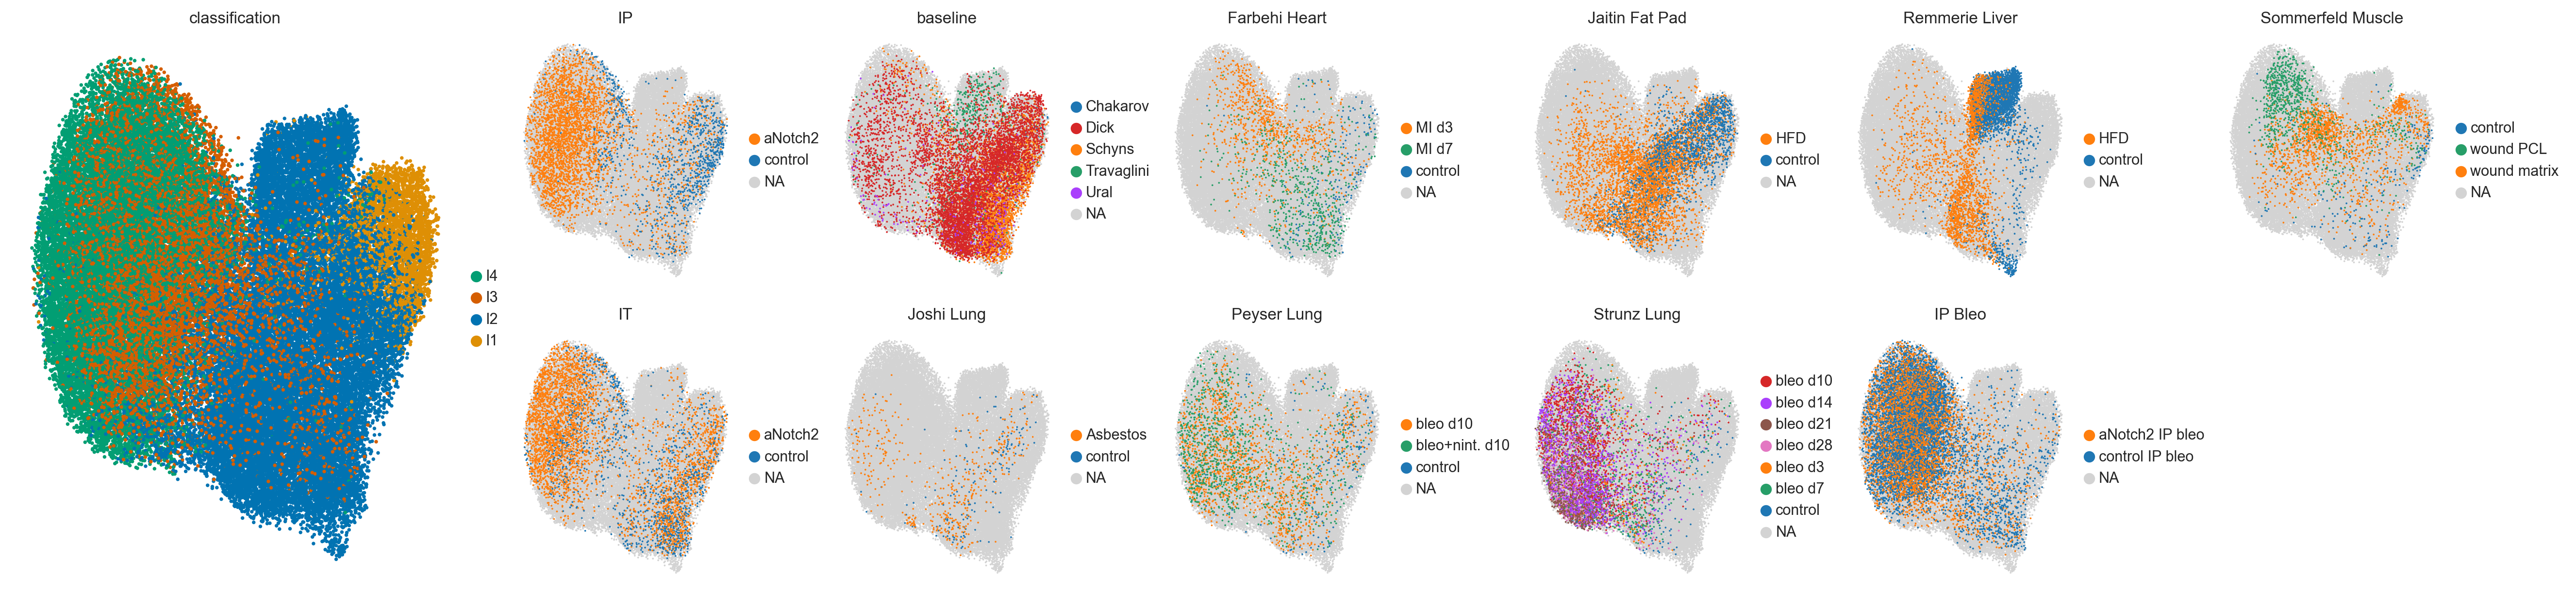

In [24]:
with plt.rc_context({"figure.figsize": (5, 4), "font.size" : 25}):
    fig3 = plt.figure(constrained_layout=True, figsize=(22, 5))
    gs = fig3.add_gridspec(2, 8)
    f3_ax1 = fig3.add_subplot(gs[0:, :-6])
    sc.pl.umap(adata, color='combined_clusters', title='classification', s=20, show=False, ax=f3_ax1)
    
    f3_ax2 = fig3.add_subplot(gs[0, 2])
    plot_adata_grp(['control IP', 'aNotch2 IP'], ['control', 'aNotch2'], 'IP', ax=f3_ax2)
    
    
    f3_ax4 = fig3.add_subplot(gs[0, 3])
    plot_adata_grp(['Chakarov', 'Schyns', 'Travaglini', 'Dick', 'Ural'], ['Chakarov', 'Schyns', 'Travaglini', 'Dick', 'Ural'], 'baseline', ax=f3_ax4)
    
    f3_ax5 = fig3.add_subplot(gs[0, 5])
    plot_adata_grp(['Jaitin control', 'Jaitin HFD'], ['control', 'HFD'], 'Jaitin Fat Pad', ax=f3_ax5)
    
    f3_ax6 = fig3.add_subplot(gs[0, 6])
    plot_adata_grp(['Remmerie control', 'Remmerie HFD'], ['control', 'HFD'], 'Remmerie Liver', ax=f3_ax6)
    
    f3_ax8 = fig3.add_subplot(gs[0, 7])
    plot_adata_grp(['Sommerfeld control', 'Sommerfeld wound matrix', 'Sommerfeld wound PCL'], ['control', 'wound matrix', 'wound PCL'], 'Sommerfeld Muscle', ax=f3_ax8)    
    
    
    f3_ax7 = fig3.add_subplot(gs[0, 4])
    plot_adata_grp(['Farbehi control', 'Farbehi MI d3', 'Farbehi MI d7'], ['control', 'MI d3', 'MI d7'], 'Farbehi Heart', ax=f3_ax7)
    
    f3_ax3 = fig3.add_subplot(gs[1, 2])
    plot_adata_grp(['control IT', 'aNotch2 IT'], ['control', 'aNotch2'], 'IT', ax=f3_ax3)

    
    f3_ax9 = fig3.add_subplot(gs[1, 3])
    plot_adata_grp(['Joshi control', 'Joshi Asbestos'], ['control', 'Asbestos'], 'Joshi Lung', ax=f3_ax9)
    
    f3_ax9 = fig3.add_subplot(gs[1, 4])
    plot_adata_grp(['Peyser control', 'Peyser bleomycin d10', 'Peyser bleomycin + nintedanib d10'], ['control', 'bleo d10', 'bleo+nint. d10'], 'Peyser Lung', ax=f3_ax9)
    
    f3_ax10 = fig3.add_subplot(gs[1, 5])
    plot_adata_grp(['Strunz control','Strunz bleomycin d3','Strunz bleomycin d7','Strunz bleomycin d10','Strunz bleomycin d14','Strunz bleomycin d21','Strunz bleomycin d28'],
               ['control','bleo d3','bleo d7','bleo d10','bleo d14','bleo d21','bleo d28'], 'Strunz Lung',
               ax=f3_ax10)
    
    f3_ax11 = fig3.add_subplot(gs[1, 6])
    plot_adata_grp(['N2 systemic bleomycin', 'control bleomycin'],
               ['control IP bleo', 'aNotch2 IP bleo'], 'IP Bleo',
               ax=f3_ax11)


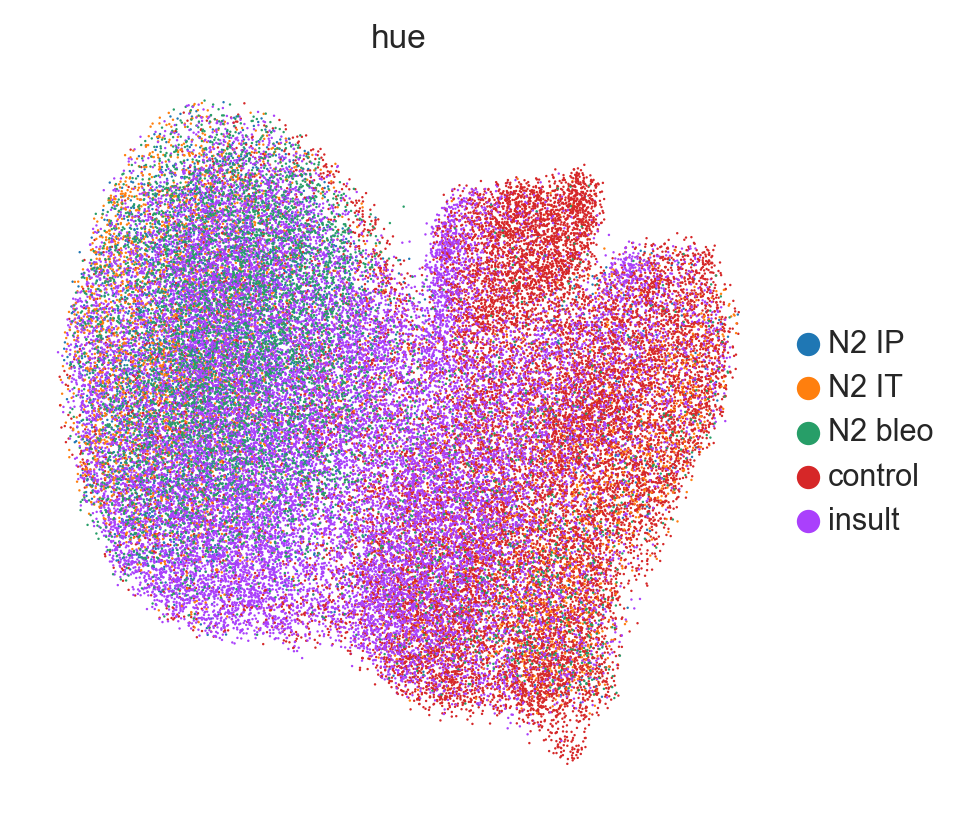

In [25]:
sc.pl.umap(adata, color='hue')

# Extended Figure 6b

In [26]:
cs_bleo = utils.cosine_similarity(adata, 'study_concise_annotation', 'X_pca_harmony')

In [27]:
cnts = utils.process_cosine_plot(adata=adata, cosine=cs_bleo, anchor=anchor).reset_index()

In [28]:
lut = {k:v for k, v in zip(cnts['hue'].unique(), adata.uns['hue_colors'])}
#row_colors = celltypes.map(lut)

tmp_dict = {k:v for k,v in zip(cnts['index'], cnts['hue'])}

for k, v in tmp_dict.items():
    tmp_dict[k] = lut[v]

In [29]:
cnts['color'] = cnts['index'].map(tmp_dict)

In [30]:
row_colors = cs_bleo.index.map(tmp_dict)

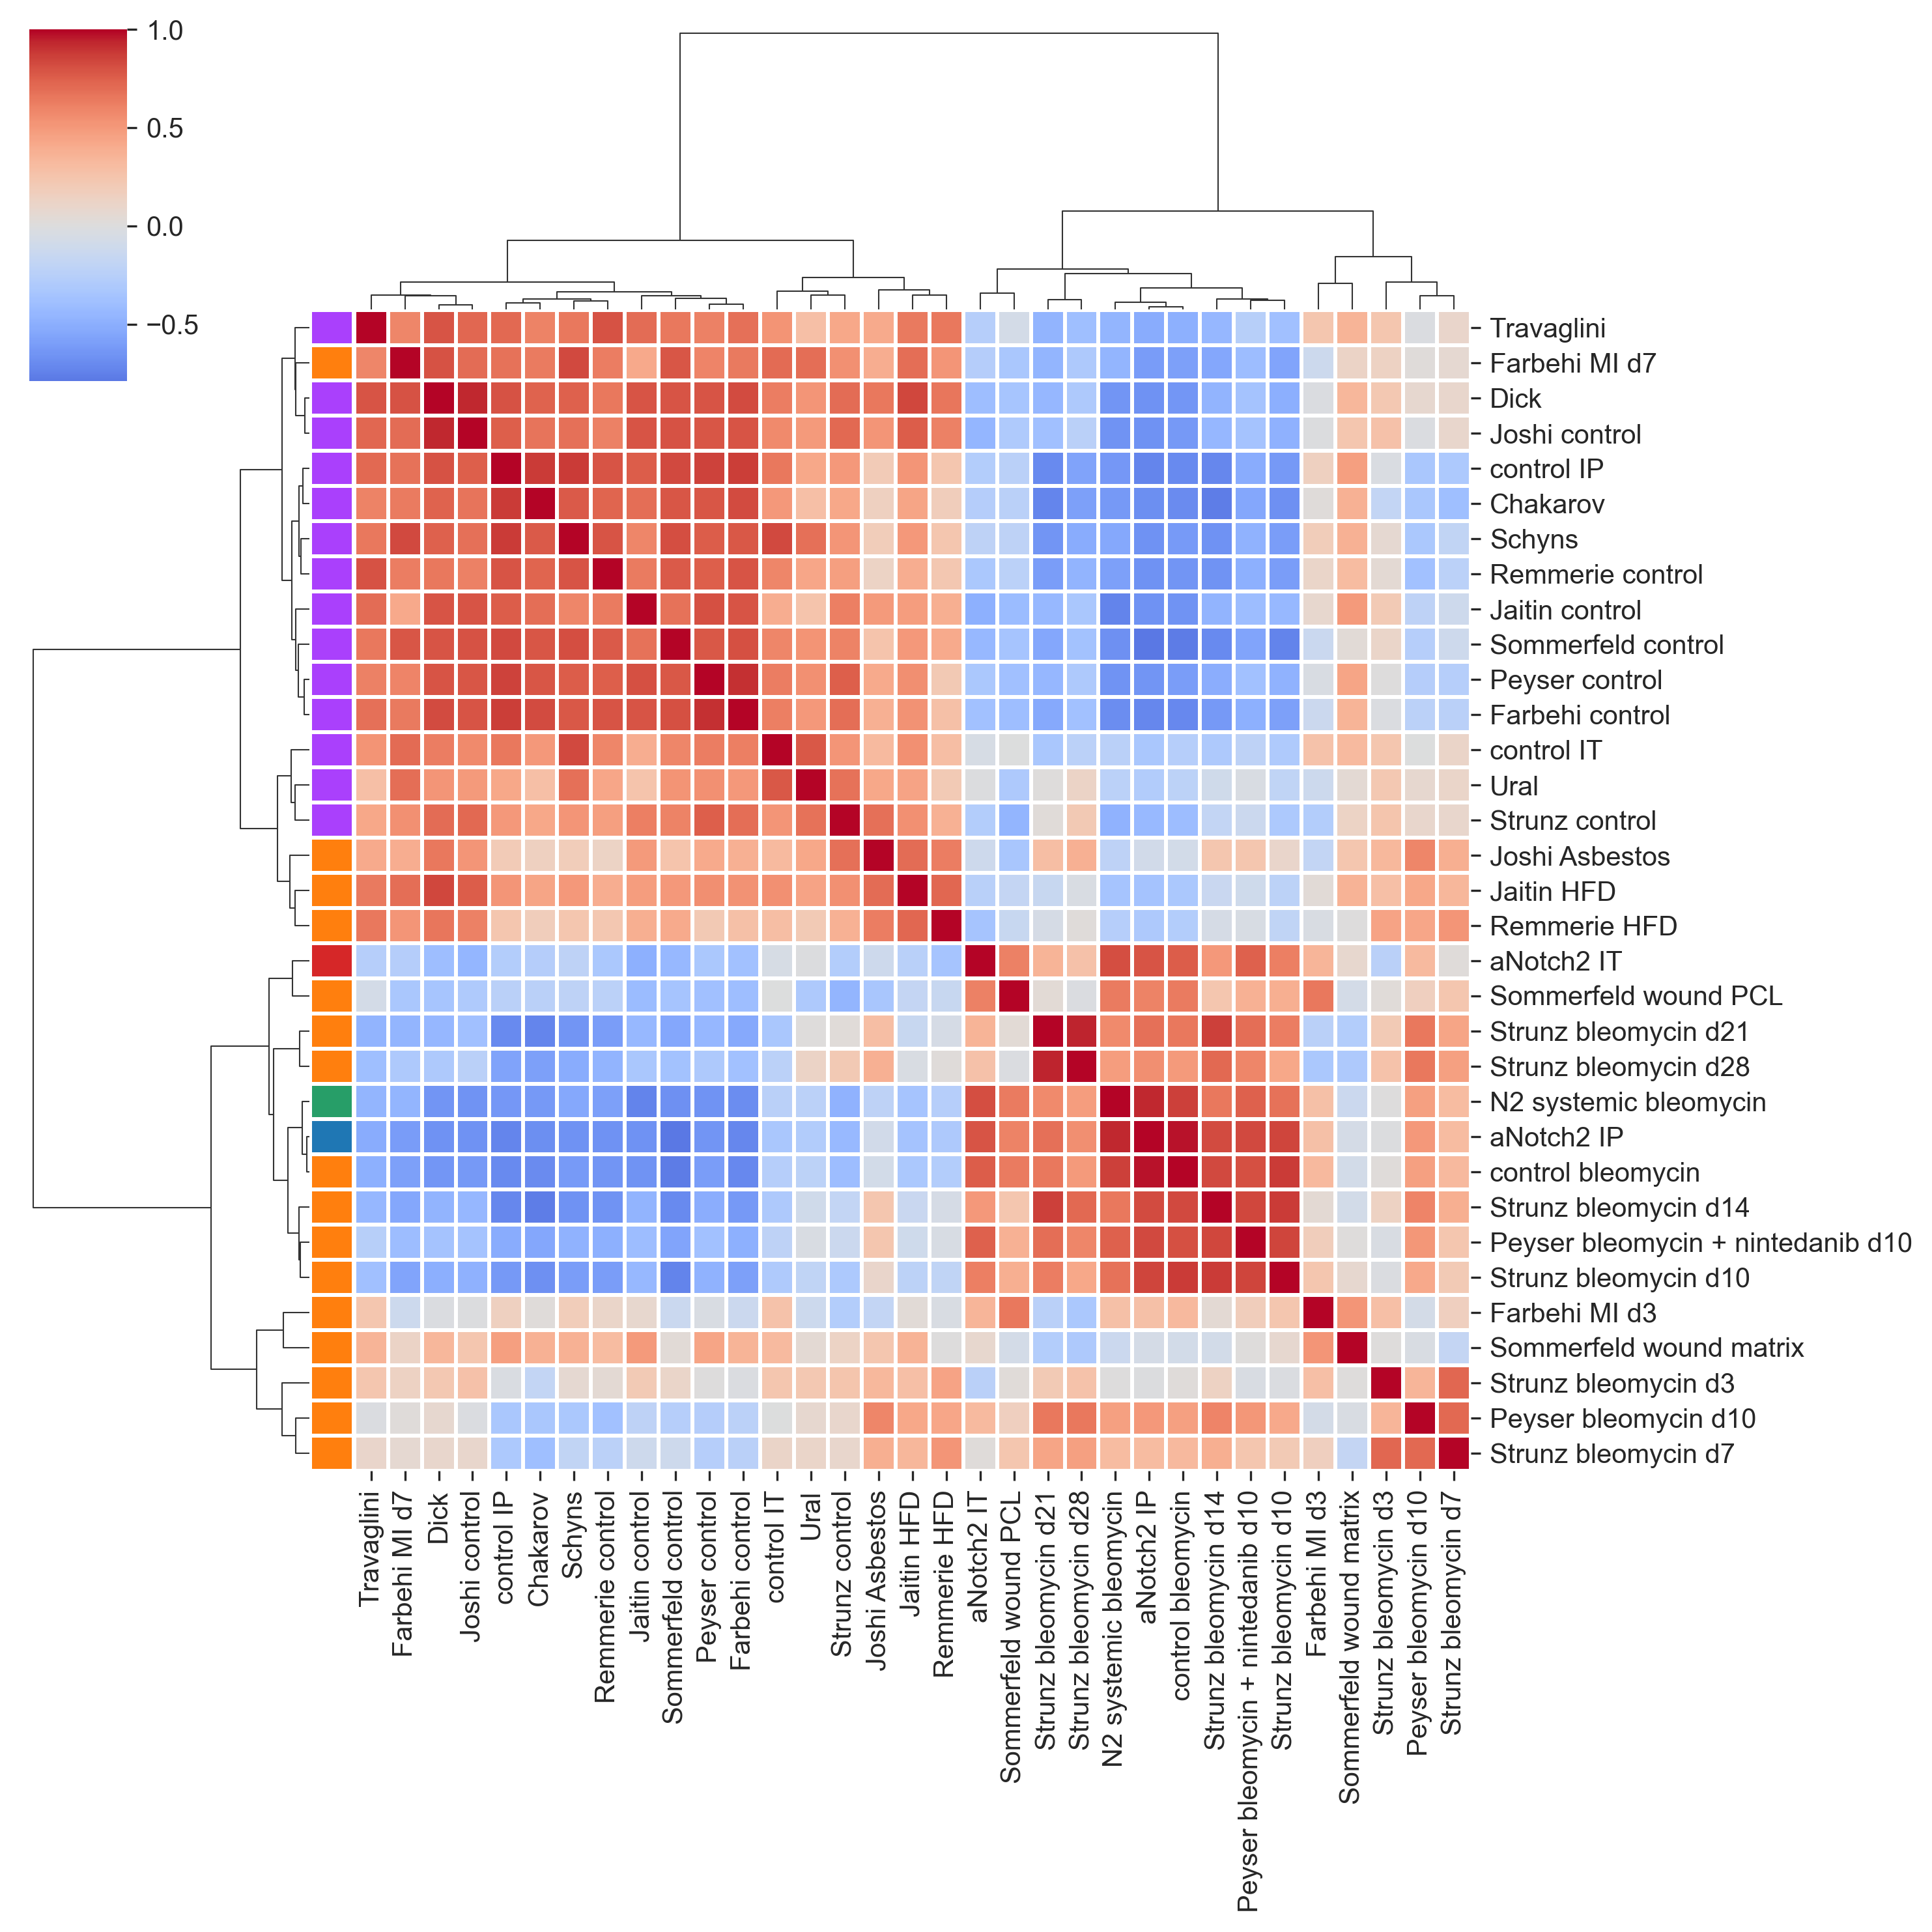

In [31]:
with plt.rc_context({"figure.dpi": (150)}):
    f = sns.clustermap(cs_bleo,
               cmap="coolwarm", figsize=(10,10), linewidth=1, method='ward', center=0,  row_colors=row_colors, xticklabels=True, yticklabels=True)
    ax.grid(False)

# Extended Figure 6c

In [32]:
cs4 = utils.cosine_similarity(adata[adata.obs['combined_clusters']=='I4'], 'study_concise_annotation', 'X_pca_harmony')

In [33]:
cnts = utils.process_cosine_plot(adata=adata, cosine=cs4, anchor=anchor).reset_index()

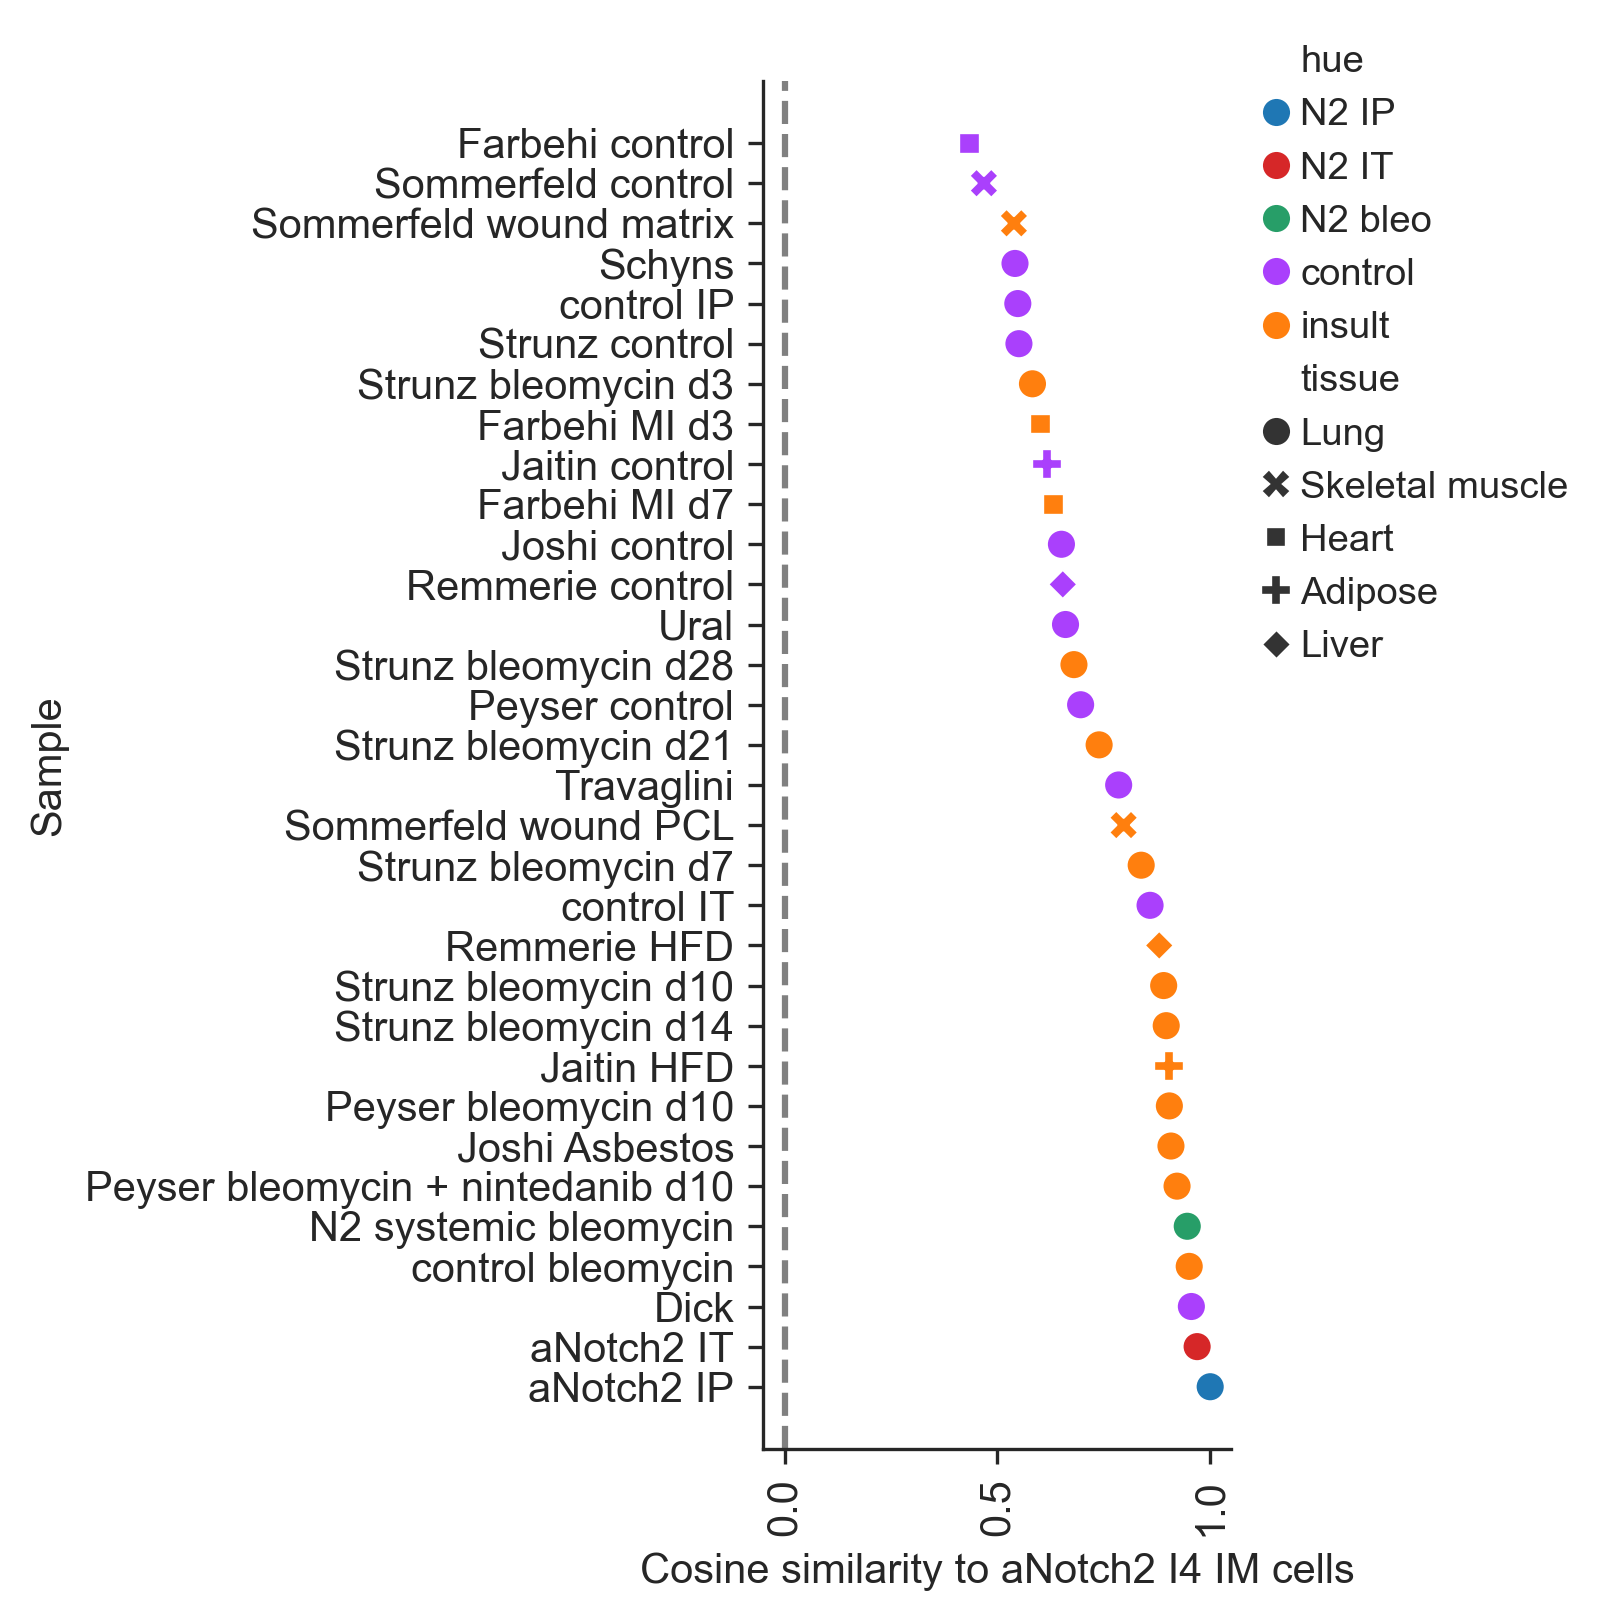

In [34]:
with plt.rc_context({"figure.dpi": (150)}):
    f, ax = plt.subplots(figsize=(2, 6))
    sns.scatterplot(data=cnts[::-1], y='index', x=anchor, ax=ax, hue='hue', style='tissue', 
                    hue_order=['N2 IP', 'N2 IT', 'N2 bleo', 'control', 'insult'],
                    style_order=['Lung', 'Skeletal muscle', 'Heart', 'Adipose', 'Liver'],
                    palette=['#1f77b4', '#d62728', '#279e68', '#aa40fc', '#ff7f0e'],
                    size_norm=(0,60), s=50)
    ax.axvline(0, color='grey', linestyle='--')
    ax.grid(None)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.8), frameon=False, ncols=1)
    #ax.annotate('', xy=(0.65, 1.05), xycoords='axes fraction', xytext=(0.96, 1.05), arrowprops=dict(arrowstyle="-", color='tab:red', linewidth=5))
    #ax.annotate('', xy=(0.47, 1.05), xycoords='axes fraction', xytext=(0.53, 1.05), arrowprops=dict(arrowstyle="-", color='tab:red', linewidth=5))
    #ax.annotate('', xy=(0.53, 1.05), xycoords='axes fraction', xytext=(0.65, 1.05), arrowprops=dict(arrowstyle="-", color='tab:orange', linewidth=5))
    ax.set_xlabel('Cosine similarity to aNotch2 I4 IM cells')
    ax.set_ylabel('Sample')
    sns.despine()
    ax.grid(False)

# Extended Figure 7g

In [35]:
select = ['aNotch2 IP', 'control IP', 'N2 systemic bleomycin', 'control bleomycin']

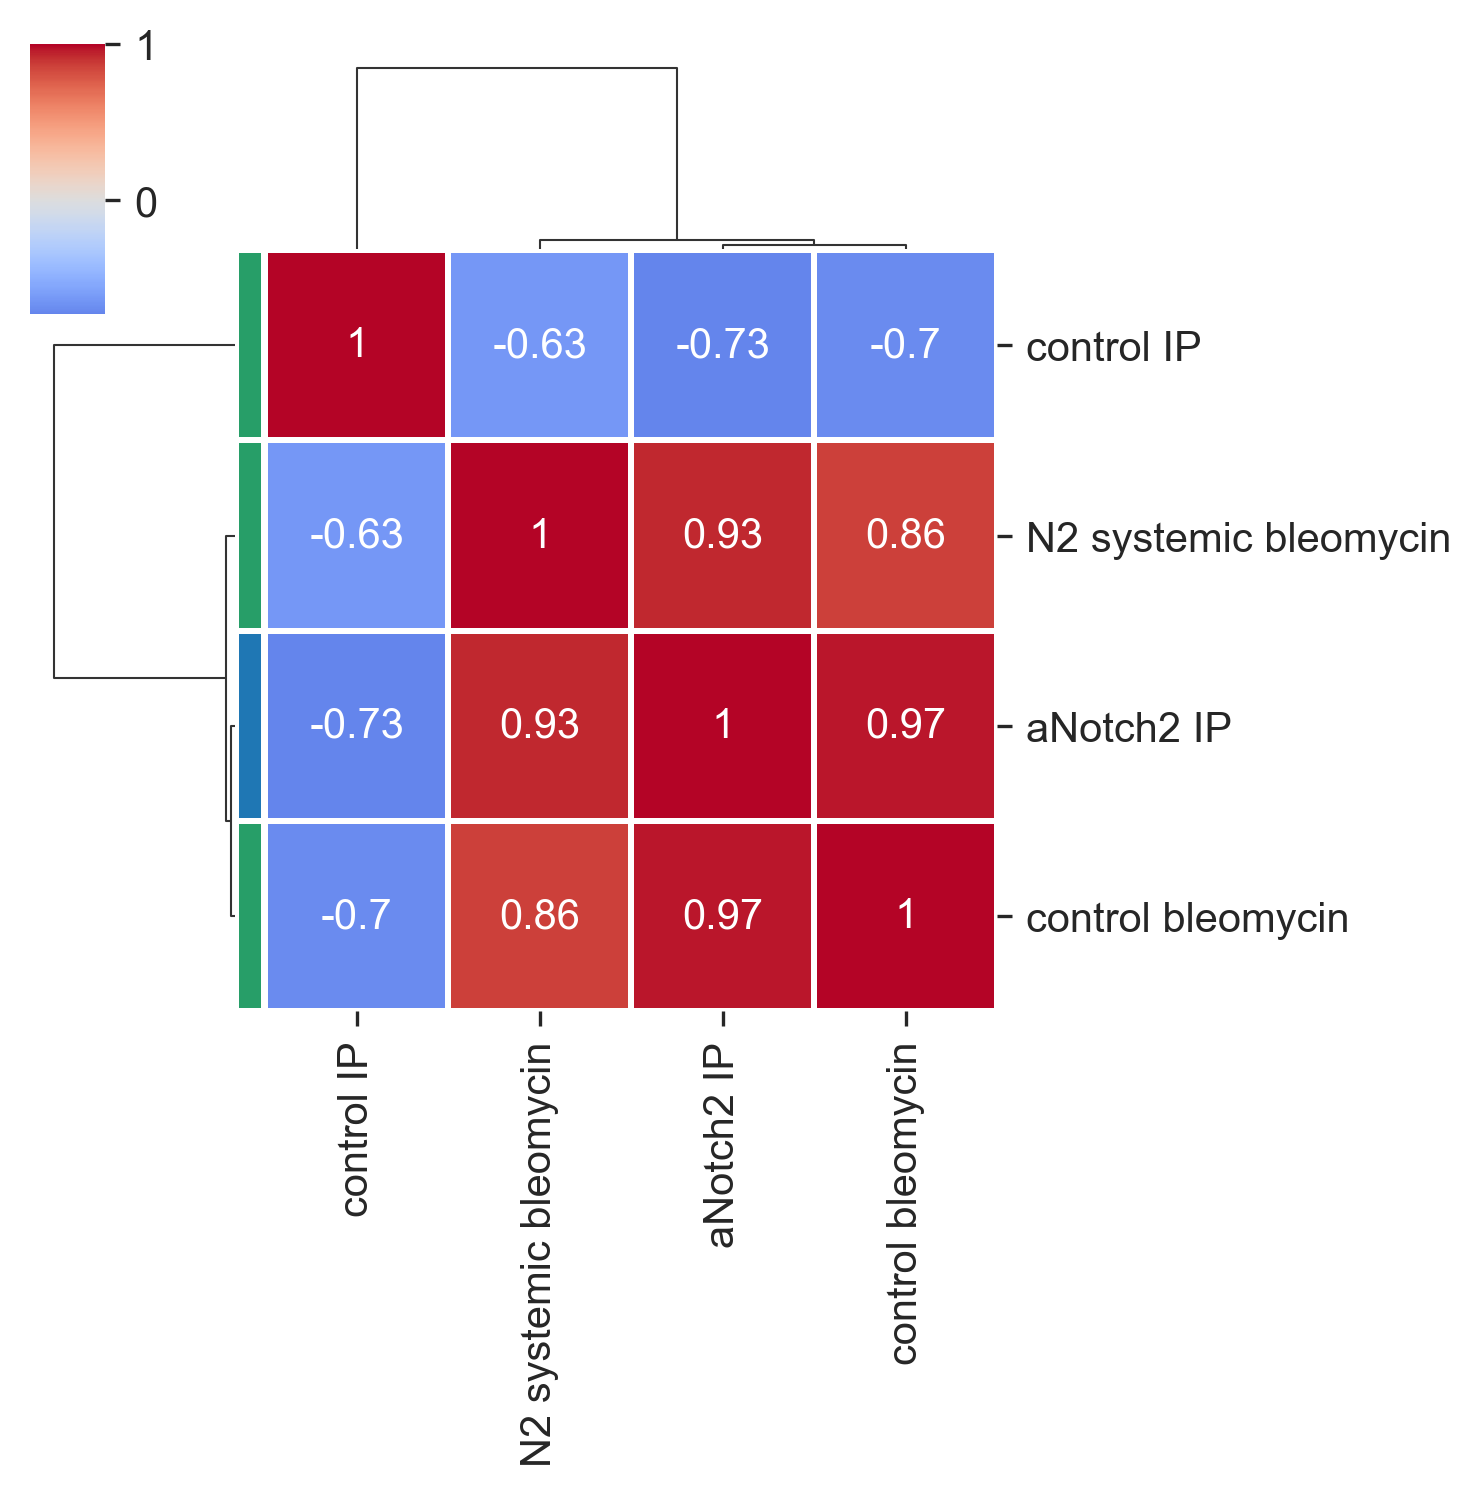

In [36]:
with plt.rc_context({"figure.dpi": (150)}):
    f = sns.clustermap(cs_bleo[select].loc[select],
               cmap="coolwarm", figsize=(5,5), linewidth=1, method='ward', center=0,  row_colors=row_colors, xticklabels=True, 
                       yticklabels=True, annot=True, fmt='.2g')